# Disparity Prediction with Sample Images

This notebook provides an example of running our proposed confidence generation process and CRD-Fusion on a pair of stereo images.

In [1]:
%matplotlib inline

import cv2
import numpy as np
import PIL.Image as PIL
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as f

from torchvision import transforms
from data_preprocess import ConfGeneration
from crd_fusion_net import CRDFusionNet

In [2]:
max_disp = 192
resized_height = 376
resized_width = 1248
device = 'cuda'
conf_threshold = 0.8

## Set up SGBM for raw disparity computation

In [3]:
block_sz = 3
pre_filter_cap = 15
p1 = block_sz * block_sz * 8
p2 = block_sz * block_sz * 64
uniqueness_ratio = 20
speckle_window_size = 150
speckle_range = 1
disp_max_diff = 1
full_dp = 1
stereo = cv2.StereoSGBM_create(numDisparities=max_disp, blockSize=block_sz, P1=p1, P2=p2,
                             disp12MaxDiff=disp_max_diff, preFilterCap=pre_filter_cap,
                             uniquenessRatio=uniqueness_ratio, speckleWindowSize=speckle_window_size,
                             speckleRange=speckle_range, mode=full_dp)

## Set up confidence generator

In [4]:
conf_generator = ConfGeneration(device, True)

## Set up CRD-Fusion

In [5]:
checkpt_path = "models/KITTI2015"  # assume the pretrained weights for KITTI2015 have been downloaded
scale_list = [0, 1, 2, 3]

model = CRDFusionNet(scale_list, max_disp, resized_height, resized_width, False, True)
model.to(device)
try:
    model.load_model(checkpt_path)
    model.eval()
except FileNotFoundError:
    print("Cannot find pretrained checkpoint")

Loading pretrained weights for disp_est
Loading pretrained weights for extractor
Loading pretrained weights for disp_refine


## Load images, compute raw disparity and confidence

In [6]:
# load images
left_im_path = "assets/left.png"
right_im_path = "assets/right.png"
left_im = PIL.open(left_im_path).convert("RGB")
right_im = PIL.open(right_im_path).convert("RGB")

# calculate raw disparity
left_im_np = np.array(left_im)
right_im_np = np.array(right_im)
raw_disp = stereo.compute(left_im_np, right_im_np) / 16.0

# calculate confidence map
to_tensor = transforms.ToTensor()
left_im_tensor = to_tensor(left_im).unsqueeze(dim=0).to(device)
right_im_tensor = to_tensor(right_im).unsqueeze(dim=0).to(device)
raw_disp_tensor = to_tensor(raw_disp).unsqueeze(dim=0).to(torch.float32).to(device)
conf_tensor = conf_generator.cal_confidence(left_im_tensor, right_im_tensor, raw_disp_tensor)
conf_tensor[conf_tensor < conf_threshold] = 0 
conf = conf_tensor.squeeze().detach().cpu().numpy()

(-0.5, 1241.5, 374.5, -0.5)

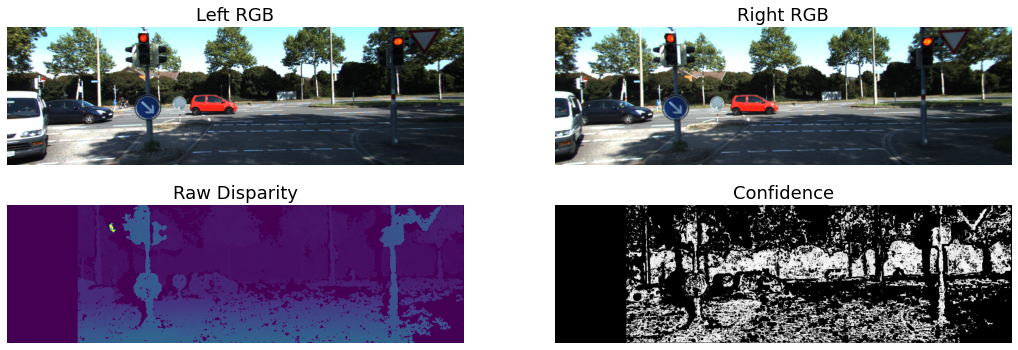

In [7]:
plt.figure(figsize=(18, 6))
plt.subplot(221)
plt.imshow(left_im)
plt.title("Left RGB", fontsize=18)
plt.axis('off')

plt.subplot(222)
plt.imshow(right_im)
plt.title("Right RGB", fontsize=18)
plt.axis('off')

plt.subplot(223)
plt.imshow(raw_disp, vmin=0, vmax=max_disp)
plt.title("Raw Disparity", fontsize=18)
plt.axis('off')

plt.subplot(224)
plt.imshow(conf, vmin=0, vmax=1, cmap='gray')
plt.title("Confidence", fontsize=18)
plt.axis('off')

## Prepare input images

In [8]:
# resize images
_, _, img_h, img_w = left_im_tensor.size()
top_pad = resized_height - img_h
left_pad = resized_width - img_w
left_im_tensor = f.pad(left_im_tensor, (left_pad, 0, top_pad, 0), 'replicate')
right_im_tensor = f.pad(right_im_tensor, (left_pad, 0, top_pad, 0), 'replicate')
raw_disp_tensor = f.pad(raw_disp_tensor, (left_pad, 0, top_pad, 0), 'replicate') / 192
conf_tensor = f.pad(conf_tensor, (left_pad, 0, top_pad, 0), 'replicate')

# normalize RGB by ImageNet statistics
rgb_norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
left_im_tensor = rgb_norm(left_im_tensor)
right_im_tensor = rgb_norm(right_im_tensor)

## Inference

In [9]:
with torch.no_grad():
    outputs = model(left_im_tensor, right_im_tensor, raw_disp_tensor, conf_tensor)
    pred_disp = outputs['refined_disp0'][:, :, top_pad:, left_pad:]
    occ_mask = outputs['occ0'][:, :, top_pad:, left_pad:]
    pred_disp = pred_disp.squeeze().detach().cpu().numpy()
    occ_mask = occ_mask.squeeze().detach().cpu().numpy()

## Visualize results

(-0.5, 1241.5, 374.5, -0.5)

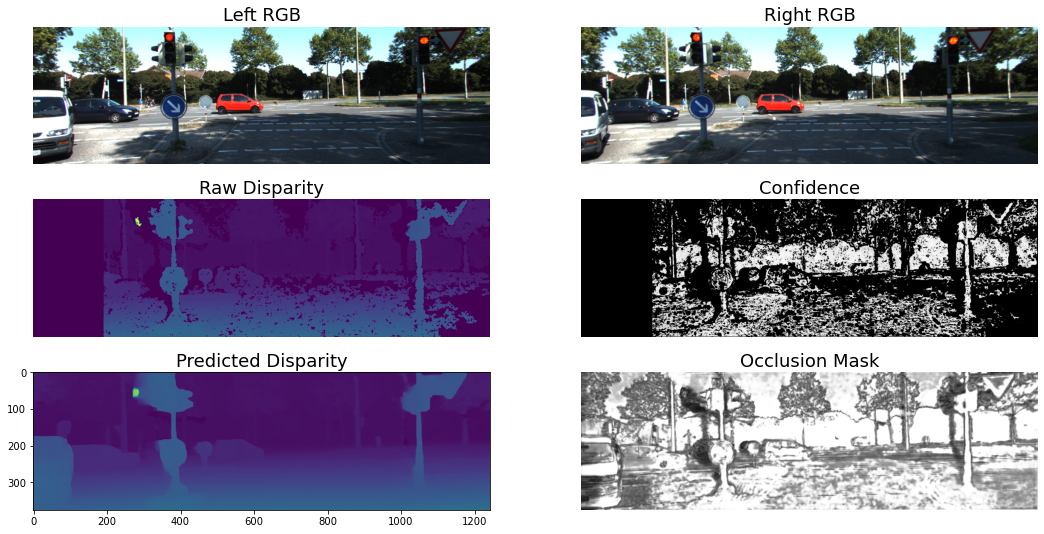

In [10]:
plt.figure(figsize=(18, 9))
plt.subplot(321)
plt.imshow(left_im)
plt.title("Left RGB", fontsize=18)
plt.axis('off')

plt.subplot(322)
plt.imshow(right_im)
plt.title("Right RGB", fontsize=18)
plt.axis('off')

plt.subplot(323)
plt.imshow(raw_disp, vmin=0, vmax=max_disp)
plt.title("Raw Disparity", fontsize=18)
plt.axis('off')

plt.subplot(324)
plt.imshow(conf, vmin=0, vmax=1, cmap='gray')
plt.title("Confidence", fontsize=18)
plt.axis('off')

plt.subplot(325)
plt.imshow(pred_disp, vmin=0, vmax=max_disp)
plt.title("Predicted Disparity", fontsize=18)

plt.subplot(326)
plt.imshow(occ_mask, vmin=0, vmax=1, cmap='gray')
plt.title("Occlusion Mask", fontsize=18)
plt.axis('off')